# How to Fine-Tune LLMs with LoRA Adapters using Hugging Face TRL

This notebook demonstrates how to efficiently fine-tune large language models using LoRA (Low-Rank Adaptation) adapters. LoRA is a parameter-efficient fine-tuning technique that:
- Freezes the pre-trained model weights
- Adds small trainable rank decomposition matrices to attention layers
- Typically reduces trainable parameters by ~90%
- Maintains model performance while being memory efficient

We'll cover:
1. Setup development environment and LoRA configuration
2. Create and prepare the dataset for adapter training
3. Fine-tune using `trl` and `SFTTrainer` with LoRA adapters
4. Test the model and merge adapters (optional)


## 1. Setup development environment

Our first step is to install Hugging Face Libraries and Pytorch, including trl, transformers and datasets. If you haven't heard of trl yet, don't worry. It is a new library on top of transformers and datasets, which makes it easier to fine-tune, rlhf, align open LLMs.


In [11]:
# Install the requirements in Google Colab
!pip install transformers datasets trl huggingface_hub

# Authenticate to Hugging Face

from huggingface_hub import login

login()

# for convenience you can create an environment variable containing your hub token as HF_TOKEN

## 2. Load the dataset

In [12]:
# Load a sample dataset
from datasets import load_dataset

# TODO: define your dataset and config using the path and name parameters
#dataset = load_dataset(path="HuggingFaceTB/smoltalk", name="everyday-conversations")
dataset = load_dataset(path="Felladrin/ChatML-open-instruct")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'source', 'task_name'],
        num_rows: 142622
    })
})

Downsampling the dataset because it is too much large for colab gpu

In [13]:
import random

def downsample(data, fraction):
    num_samples = int(len(data) * fraction)
    indices = list(range(len(data)))
    selected_indices = sorted(random.sample(indices, num_samples))
    return data.select(selected_indices)

In [14]:
dataset['train'] = downsample(dataset['train'], 0.05)

In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'source', 'task_name'],
        num_rows: 7131
    })
})

Util function to format the dataset in the format required from TRL

In [16]:
import re

PATTERN_USER=r"<\|im_start\|>user(.*?)<\|im_end\|>"
PATTERN_ASSISTANT = r"<\|im_start\|>assistant(.*?)<\|im_end\|>"

def process_dataset(sample):

  user_messages = []
  assistant_messages = []

  # find user messages
  user_matches = re.findall(PATTERN_USER, sample['text'], re.DOTALL)
  if user_matches:
    user_messages = [um.strip() for um in user_matches]

  # find assistant messages
  assistant_matches = re.findall(PATTERN_ASSISTANT, sample['text'], re.DOTALL)
  if assistant_matches:
    assistant_messages = [am.strip() for am in assistant_matches]


  # Initialize message
  messages = []

  # Iterate over the sections and assign them to the appropriate list
  for um, am in zip(user_messages, assistant_messages):
        # Even indices contain human parts
        messages.append(
            {
                "role": "user",
                "content": um
            })
        messages.append(
            {
                "role": "assistant",
                "content": am
            }
        )


  return messages


In [17]:
dataset = dataset.map(lambda x: {'messages': process_dataset(x)})

Map:   0%|          | 0/7131 [00:00<?, ? examples/s]

Split the data in train and test

In [18]:
dataset = dataset['train'].train_test_split(test_size=0.3)

In [19]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'source', 'task_name', 'messages'],
        num_rows: 4991
    })
    test: Dataset({
        features: ['text', 'source', 'task_name', 'messages'],
        num_rows: 2140
    })
})

## 3. Fine-tune LLM using `trl` and the `SFTTrainer` with LoRA

The [SFTTrainer](https://huggingface.co/docs/trl/sft_trainer) from `trl` provides integration with LoRA adapters through the [PEFT](https://huggingface.co/docs/peft/en/index) library. Key advantages of this setup include:

1. **Memory Efficiency**:
   - Only adapter parameters are stored in GPU memory
   - Base model weights remain frozen and can be loaded in lower precision
   - Enables fine-tuning of large models on consumer GPUs

2. **Training Features**:
   - Native PEFT/LoRA integration with minimal setup
   - Support for QLoRA (Quantized LoRA) for even better memory efficiency

3. **Adapter Management**:
   - Adapter weight saving during checkpoints
   - Features to merge adapters back into base model

We'll use LoRA in our example, which combines LoRA with 4-bit quantization to further reduce memory usage without sacrificing performance. The setup requires just a few configuration steps:
1. Define the LoRA configuration (rank, alpha, dropout)
2. Create the SFTTrainer with PEFT config
3. Train and save the adapter weights


In [20]:
# Import necessary libraries
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from trl import SFTConfig, SFTTrainer, setup_chat_format
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

# Load the model and tokenizer
model_name = "HuggingFaceTB/SmolLM2-135M"

model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_name
).to(device)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name)

# Set up the chat format
model, tokenizer = setup_chat_format(model=model, tokenizer=tokenizer)

# Set our name for the finetune to be saved &/ uploaded to
finetune_name = "SmolLM2-FT-MyDataset"
finetune_tags = ["smol-course", "module_1"]

The `SFTTrainer`  supports a native integration with `peft`, which makes it super easy to efficiently tune LLMs using, e.g. LoRA. We only need to create our `LoraConfig` and provide it to the trainer.

<div style='background-color: lightblue; padding: 10px; border-radius: 5px; margin-bottom: 20px; color:black'>
    <h2 style='margin: 0;color:blue'>Exercise: Define LoRA parameters for finetuning</h2>
    <p>Take a dataset from the Hugging Face hub and finetune a model on it. </p>
    <p><b>Difficulty Levels</b></p>
    <p>🐢 Use the general parameters for an abitrary finetune</p>
    <p>🐕 Adjust the parameters and review in weights & biases.</p>
    <p>🦁 Adjust the parameters and show change in inference results.</p>
</div>

Use this function in order to get all the linear layers of the models

In [22]:
def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    multimodal_keywords = ['mm_projector', 'vision_tower', 'vision_resampler']
    for name, module in model.named_modules():
        if any(mm_keyword in name for mm_keyword in multimodal_keywords):
            continue
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names: # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


linear_layers = find_all_linear_names(model)

In [23]:
from peft import LoraConfig

# TODO: Configure LoRA parameters
# r: rank dimension for LoRA update matrices (smaller = more compression)
rank_dimension = 6
# lora_alpha: scaling factor for LoRA layers (higher = stronger adaptation)
lora_alpha = 8
# lora_dropout: dropout probability for LoRA layers (helps prevent overfitting)
lora_dropout = 0.05

peft_config = LoraConfig(
    r=rank_dimension,  # Rank dimension - typically between 4-32
    lora_alpha=lora_alpha,  # LoRA scaling factor - typically 2x rank
    lora_dropout=lora_dropout,  # Dropout probability for LoRA layers
    bias="none",  # Bias type for LoRA. the corresponding biases will be updated during training.
    #target_modules="all-linear",  # Which modules to apply LoRA to
    target_modules=linear_layers,  # Which modules to apply LoRA to
    task_type="CAUSAL_LM",  # Task type for model architecture
)

Before we can start our training we need to define the hyperparameters (`TrainingArguments`) we want to use.

In [25]:
max_seq_length = 1512  # max sequence length for model and packing of the dataset

# Training configuration
# Hyperparameters based on QLoRA paper recommendations
args = SFTConfig(
    # Output settings
    output_dir=finetune_name,  # Directory to save model checkpoints
    # Training duration
    num_train_epochs=1,  # Number of training epochs
    # Batch size settings
    per_device_train_batch_size=2,  # Batch size per GPU
    gradient_accumulation_steps=2,  # Accumulate gradients for larger effective batch
    # Memory optimization
    gradient_checkpointing=True,  # Trade compute for memory savings
    # Optimizer settings
    optim="adamw_torch_fused",  # Use fused AdamW for efficiency
    learning_rate=2e-4,  # Learning rate (QLoRA paper)
    max_grad_norm=0.3,  # Gradient clipping threshold
    # Learning rate schedule
    warmup_ratio=0.03,  # Portion of steps for warmup
    lr_scheduler_type="constant",  # Keep learning rate constant after warmup
    # Logging and saving
    logging_steps=10,  # Log metrics every N steps
    save_strategy="epoch",  # Save checkpoint every epoch
    # Precision settings
    bf16=True,  # Use bfloat16 precision
    # Integration settings
    push_to_hub=False,  # Don't push to HuggingFace Hub
    report_to="none",  # Disable external logging
    packing=True,  # Enable input packing for efficiency
    dataset_kwargs={
        "add_special_tokens": False,  # Special tokens handled by template
        "append_concat_token": False,  # No additional separator needed
    },
    max_seq_length=max_seq_length
)

We now have every building block we need to create our `SFTTrainer` to start then training our model.

In [26]:
# Create SFTTrainer with LoRA configuration
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    peft_config=peft_config,  # LoRA configuration
    tokenizer=tokenizer
)

<ipython-input-26-6512e818b82e>:2: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Generating train split: 0 examples [00:00, ? examples/s]

Start training our model by calling the `train()` method on our `Trainer` instance. This will start the training loop and train our model for 3 epochs. Since we are using a PEFT method, we will only save the adapted model weights and not the full model.

In [27]:
# start training, the model will be automatically saved to the hub and the output directory
trainer.train()

# save model
#trainer.save_model()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
10,5.058200
20,5.007400
30,4.916500
40,4.775400
50,4.707900
60,4.642700
70,4.451200
80,4.291500
90,4.304700
100,4.339100


TrainOutput(global_step=109, training_loss=4.6107682394325185, metrics={'train_runtime': 340.9239, 'train_samples_per_second': 1.279, 'train_steps_per_second': 0.32, 'total_flos': 427321312653312.0, 'train_loss': 4.6107682394325185, 'epoch': 1.0})

In [28]:
trainer.save_model()

The training with Flash Attention for 3 epochs with a dataset of 15k samples took 4:14:36 on a `g5.2xlarge`. The instance costs `1.21$/h` which brings us to a total cost of only ~`5.3$`.



### Merge LoRA Adapter into the Original Model

When using LoRA, we only train adapter weights while keeping the base model frozen. During training, we save only these lightweight adapter weights (~2-10MB) rather than a full model copy. However, for deployment, you might want to merge the adapters back into the base model for:

1. **Simplified Deployment**: Single model file instead of base model + adapters
2. **Inference Speed**: No adapter computation overhead
3. **Framework Compatibility**: Better compatibility with serving frameworks


In [29]:
from peft import AutoPeftModelForCausalLM


# Load PEFT model on CPU
model = AutoPeftModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=args.output_dir,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
)

# Merge LoRA and base model and save
merged_model = model.merge_and_unload()
merged_model.save_pretrained(
    args.output_dir, safe_serialization=True, max_shard_size="2GB"
)

## 3. Test Model and run Inference

After the training is done we want to test our model. We will load different samples from the original dataset and evaluate the model on those samples, using a simple loop and accuracy as our metric.



<div style='background-color: lightblue; padding: 10px; border-radius: 5px; margin-bottom: 20px; color:black'>
    <h2 style='margin: 0;color:blue'>Bonus Exercise: Load LoRA Adapter</h2>
    <p>Use what you learnt from the ecample note book to load your trained LoRA adapter for inference.</p>
</div>

In [30]:
# free the memory again
del model
del trainer
torch.cuda.empty_cache()

In [31]:
import torch
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer, pipeline

# Load Model with PEFT adapter
tokenizer = AutoTokenizer.from_pretrained(finetune_name)
model = AutoPeftModelForCausalLM.from_pretrained(
    finetune_name, device_map="auto", torch_dtype=torch.float16
)
pipe = pipeline(
    "text-generation", model=merged_model, tokenizer=tokenizer, device=device
)

Device set to use cuda


Lets test some prompt samples and see how the model performs.

In [32]:
prompts = [
    "What is the capital of Germany? Explain why thats the case and if it was different in the past?",
    "Write a Python function to calculate the factorial of a number.",
    "A rectangular garden has a length of 25 feet and a width of 15 feet. If you want to build a fence around the entire garden, how many feet of fencing will you need?",
    "What is the difference between a fruit and a vegetable? Give examples of each.",
]


def test_inference(prompt):
    prompt = pipe.tokenizer.apply_chat_template(
        [{"role": "user", "content": prompt}],
        tokenize=False,
        add_generation_prompt=True,
    )
    outputs = pipe(
        prompt,
    )
    return outputs[0]["generated_text"][len(prompt) :].strip()


for prompt in prompts:
    print(f"    prompt:\n{prompt}")
    print(f"    response:\n{test_inference(prompt)}")
    print("-" * 50)

    prompt:
What is the capital of Germany? Explain why thats the case and if it was different in the past?
    response:
The capital of Germany is Berlin. Berlin is the capital of Germany and the largest city in Germany.
--------------------------------------------------
    prompt:
Write a Python function to calculate the factorial of a number.
    response:
The factorial of a number is the product of all the natural numbers less than or equal to that
--------------------------------------------------
    prompt:
A rectangular garden has a length of 25 feet and a width of 15 feet. If you want to build a fence around the entire garden, how many feet of fencing will you need?
    response:
The garden is 25 feet long and 15 feet wide. The garden is 1
--------------------------------------------------
    prompt:
What is the difference between a fruit and a vegetable? Give examples of each.
    response:
A fruit is a plant that is edible and has a sweet taste. A vegetable is a plant that

# LoRa Hyperparameter search

In [ ]:
del model

In [33]:
# Load the model and tokenizer
model_name = "HuggingFaceTB/SmolLM2-135M"

model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_name
).to(device)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name)

# Set up the chat format
model, tokenizer = setup_chat_format(model=model, tokenizer=tokenizer)

In [35]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: francesco-arno94dev (francesco-arno94dev-me). Use `wandb login --relogin` to force relogin


True

In [ ]:
%env WANDB_PROJECT=vit_snacks_sweeps_lora_peft_smol_v6

In [36]:

## result : ['default', 'base_layer']
linear_layers = find_all_linear_names(model)

Using sweep method from wandb in order to do the hyperparameter search

In [37]:

# method
sweep_config = {
    'method': 'random',
     'metric': {"name": "eval/loss", "goal": "minimize"}
}


# hyperparameters
parameters_dict = {
    'rank_dimension': {
        'distribution': 'int_uniform',
        'min': 4,
        'max': 32
    },
    'lora_alpha': {
        # integers between 6 and 32
        # with evenly-distributed logarithms
        'distribution': 'q_log_uniform_values',
        'q': 4,
        'min': 8,
        'max': 32,
    }
}


sweep_config['parameters'] = parameters_dict


In [38]:
# Training configuration
# Hyperparameters based on QLoRA paper recommendations
max_seq_length = 1512  # max sequence length for model and packing of the dataset

args = SFTConfig(
    # Output settings
    output_dir=finetune_name,  # Directory to save model checkpoints
    # Training duration
    num_train_epochs=1,  # Number of training epochs
    # Batch size settings
    per_device_train_batch_size=2,  # Batch size per GPU
    gradient_accumulation_steps=2,  # Accumulate gradients for larger effective batch
    # Memory optimization
    gradient_checkpointing=True,  # Trade compute for memory savings
    # Optimizer settings
    optim="adamw_torch_fused",  # Use fused AdamW for efficiency
    learning_rate=2e-4,  # Learning rate (QLoRA paper)
    max_grad_norm=0.3,  # Gradient clipping threshold
    # Learning rate schedule
    warmup_ratio=0.03,  # Portion of steps for warmup
    lr_scheduler_type="constant",  # Keep learning rate constant after warmup
    # Logging and saving
    logging_steps=10,  # Log metrics every N steps
    save_strategy="epoch",  # Save checkpoint every epoch
    # Precision settings
    bf16=True,  # Use bfloat16 precision
    # Integration settings
    push_to_hub=False,  # Don't push to HuggingFace Hub
    #report_to="none",  # Disable external logging,
    packing=True,  # Enable input packing for efficiency
    dataset_kwargs={
        "add_special_tokens": False,  # Special tokens handled by template
        "append_concat_token": False,  # No additional separator needed
    },
    max_seq_length=max_seq_length,  # Maximum sequence length
    eval_steps=10,
    per_device_eval_batch_size=2,
    do_eval=True,
    evaluation_strategy='steps'
)

from peft import LoraConfig

def train(config=None):
    with wandb.init(config=config):
        # set sweep configuration
        config = wandb.config
        print(config)
        lora_dropout = 0.05

        peft_config = LoraConfig(
            r=config.rank_dimension,  # Rank dimension - typically between 4-32
            lora_alpha=config.lora_alpha,  # LoRA scaling factor - typically 2x rank
            lora_dropout=lora_dropout,  # Dropout probability for LoRA layers
            bias="none",  # Bias type for LoRA. the corresponding biases will be updated during training.
            #target_modules="all-linear",  # Which modules to apply LoRA to
            target_modules=linear_layers,  # Which modules to apply LoRA to
            task_type="CAUSAL_LM",  # Task type for model architecture
        )


        trainer = SFTTrainer(
        model=model,
        args=args,
        train_dataset=dataset["train"],
        peft_config=peft_config,  # LoRA configuration
        tokenizer=tokenizer,
        eval_dataset=dataset["test"]
        )

        trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [39]:
sweep_id = wandb.sweep(sweep_config, project='vit_snacks_sweeps_lora_peft_smol_v7')
wandb.agent(sweep_id, train, count=4)

Create sweep with ID: dlr3r5wy
Sweep URL: https://wandb.ai/francesco-arno94dev-me/vit_snacks_sweeps_lora_peft_smol_v7/sweeps/dlr3r5wy


wandb: Agent Starting Run: ojxvlmjs with config:
wandb: 	lora_alpha: 8
wandb: 	rank_dimension: 29


{'lora_alpha': 8, 'rank_dimension': 29}


<ipython-input-38-25f04434aa05>:62: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Generating train split: 0 examples [00:00, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss
10,5.058900,2.520585
20,5.008400,2.457865
30,4.916600,2.399913
40,4.775000,2.347744
50,4.705600,2.298870
60,4.640800,2.253196
70,4.451100,2.211155
80,4.292800,2.173044
90,4.305500,2.138329
100,4.341700,2.105908


eval/loss,█▇▆▅▄▃▃▂▂▁
eval/runtime,▂▂▆▁▆▄▄▄▆█
eval/samples_per_second,▆▆▃█▃▆▆▆▃▁
eval/steps_per_second,█████████▁
train/epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
train/global_step,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
train/grad_norm,▁▁▂▄▄▅▄▆▃█
train/learning_rate,▁▁▁▁▁▁▁▁▁▁
train/loss,██▇▅▅▄▂▁▁▁
eval/loss,2.10591
eval/runtime,43.0991


wandb: Agent Starting Run: xo7cdh7a with config:
wandb: 	lora_alpha: 12
wandb: 	rank_dimension: 18


{'lora_alpha': 12, 'rank_dimension': 18}


<ipython-input-38-25f04434aa05>:62: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Step,Training Loss,Validation Loss
10,5.127000,2.492580
20,4.880700,2.421804
30,4.724000,2.360551
40,4.750700,2.302856
50,4.543800,2.247999
60,4.424700,2.197260
70,4.389800,2.155972
80,4.339300,2.115409
90,4.301800,2.079966
100,4.358300,2.047046


eval/loss,█▇▆▅▄▃▃▂▂▁
eval/runtime,▆▆█▄▇▆▃▂▁▃
eval/samples_per_second,▅▁▁▅▁▁▅██▅
eval/steps_per_second,▁▁▁█▁▁████
train/epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
train/global_step,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
train/grad_norm,▁▃▁▁▄▂▂▅█▅
train/learning_rate,▁▁▁▁▁▁▁▁▁▁
train/loss,█▆▅▅▃▂▂▁▁▁
eval/loss,2.04705
eval/runtime,43.0911


wandb: Agent Starting Run: x7rltpq7 with config:
wandb: 	lora_alpha: 8
wandb: 	rank_dimension: 17


{'lora_alpha': 8, 'rank_dimension': 17}


<ipython-input-38-25f04434aa05>:62: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Step,Training Loss,Validation Loss
10,5.141100,2.511377
20,4.925400,2.450064
30,4.782700,2.394997
40,4.823600,2.343271
50,4.632100,2.294076
60,4.515200,2.248439
70,4.482300,2.207927
80,4.445600,2.168595
90,4.406300,2.132940
100,4.451700,2.100663


eval/loss,█▇▆▅▄▄▃▂▂▁
eval/runtime,▂▃▃▂▃▂▂▁▃█
eval/samples_per_second,█▇▇▇▇███▇▁
eval/steps_per_second,▆▆▆▆▆▆▆█▆▁
train/epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
train/global_step,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
train/grad_norm,▂▄▁▂█▃▃▅▇▆
train/learning_rate,▁▁▁▁▁▁▁▁▁▁
train/loss,█▆▅▅▃▂▂▁▁▁
eval/loss,2.10066
eval/runtime,43.1409


wandb: Agent Starting Run: 270bzpcp with config:
wandb: 	lora_alpha: 24
wandb: 	rank_dimension: 6


{'lora_alpha': 24, 'rank_dimension': 6}


<ipython-input-38-25f04434aa05>:62: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Step,Training Loss,Validation Loss
10,5.083500,2.447160
20,4.774600,2.359369
30,4.594400,2.283867
40,4.593200,2.219191
50,4.369800,2.160172
60,4.260300,2.108318
70,4.226900,2.065974
80,4.162800,2.027960
90,4.135500,1.996620
100,4.215500,1.970367


eval/loss,█▇▆▅▄▃▂▂▁▁
eval/runtime,▄▂▃▁▂▁█▃▁▃
eval/samples_per_second,▆█▆███▁▆█▆
eval/steps_per_second,▅▅▅▅▅█▁▅█▅
train/epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
train/global_step,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
train/grad_norm,▁▂▁▁▂▂▂▅█▄
train/learning_rate,▁▁▁▁▁▁▁▁▁▁
train/loss,█▆▄▄▃▂▂▁▁▂
eval/loss,1.97037
eval/runtime,42.9369


Output of hyperparameters

<>:3: SyntaxWarning: invalid escape sequence '\i'
<>:3: SyntaxWarning: invalid escape sequence '\i'
C:\Users\utente\AppData\Local\Temp\ipykernel_8136\288755796.py:3: SyntaxWarning: invalid escape sequence '\i'
  Image('..\images\hyperparameter_search_wandb.png')


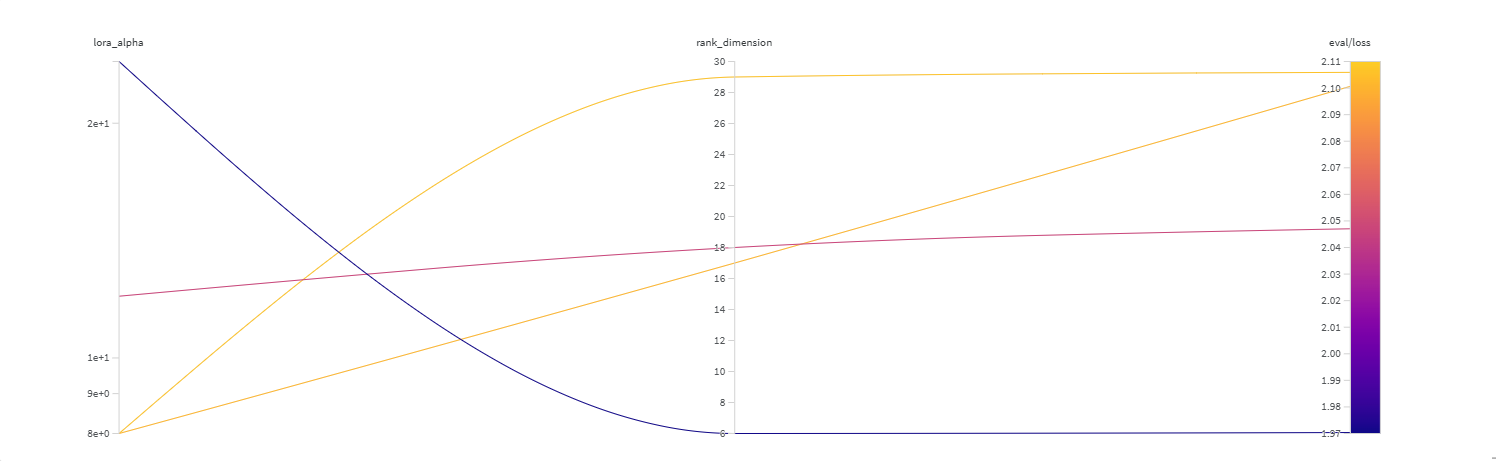

In [1]:
%matplotlib inline
from IPython.display import Image
Image('..\images\hyperparameter_search_wandb.png')

In [2]:
# retrain with the best hyper-parameters
rank_dimension=6
lora_alpha=24

In [ ]:
max_seq_length = 1512  # max sequence length for model and packing of the dataset

args = SFTConfig(
    # Output settings
    output_dir=finetune_name,  # Directory to save model checkpoints
    # Training duration
    num_train_epochs=1,  # Number of training epochs
    # Batch size settings
    per_device_train_batch_size=2,  # Batch size per GPU
    gradient_accumulation_steps=2,  # Accumulate gradients for larger effective batch
    # Memory optimization
    gradient_checkpointing=True,  # Trade compute for memory savings
    # Optimizer settings
    optim="adamw_torch_fused",  # Use fused AdamW for efficiency
    learning_rate=2e-4,  # Learning rate (QLoRA paper)
    max_grad_norm=0.3,  # Gradient clipping threshold
    # Learning rate schedule
    warmup_ratio=0.03,  # Portion of steps for warmup
    lr_scheduler_type="constant",  # Keep learning rate constant after warmup
    # Logging and saving
    logging_steps=10,  # Log metrics every N steps
    save_strategy="epoch",  # Save checkpoint every epoch
    # Precision settings
    bf16=True,  # Use bfloat16 precision
    # Integration settings
    push_to_hub=False,  # Don't push to HuggingFace Hub
    report_to="none",  # Disable external logging,
    packing=True,  # Enable input packing for efficiency
    dataset_kwargs={
        "add_special_tokens": False,  # Special tokens handled by template
        "append_concat_token": False,  # No additional separator needed
    },
    max_seq_length=max_seq_length,  # Maximum sequence length
)

peft_config = LoraConfig(
            r=rank_dimension,  # Rank dimension - typically between 4-32
            lora_alpha=lora_alpha,  # LoRA scaling factor - typically 2x rank
            lora_dropout=lora_dropout,  # Dropout probability for LoRA layers
            bias="none",  # Bias type for LoRA. the corresponding biases will be updated during training.
            #target_modules="all-linear",  # Which modules to apply LoRA to
            target_modules=linear_layers,  # Which modules to apply LoRA to
            task_type="CAUSAL_LM",  # Task type for model architecture
        )


trainer = SFTTrainer(
model=model,
args=args,
train_dataset=dataset["train"],
peft_config=peft_config,  # LoRA configuration
tokenizer=tokenizer,
)

trainer.train()
trainer.save_model()

<ipython-input-41-dd195e91ef15>:47: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Step,Training Loss
10,5.083500
20,4.774600
30,4.594400
40,4.593200
50,4.369800
60,4.260300
70,4.226900
80,4.162800
90,4.135500
100,4.215500


In [ ]:
from peft import AutoPeftModelForCausalLM


# Load PEFT model on CPU
model = AutoPeftModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=args.output_dir,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
)

# Merge LoRA and base model and save
merged_model = model.merge_and_unload()
merged_model.save_pretrained(
    args.output_dir, safe_serialization=True, max_shard_size="2GB"
)

In [42]:
import torch
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer, pipeline

# Load Model with PEFT adapter
tokenizer = AutoTokenizer.from_pretrained(finetune_name)

pipe = pipeline(
    "text-generation", model=merged_model, tokenizer=tokenizer, device=device
)

Device set to use cuda


In [43]:
prompts = [
    "What is the capital of Germany? Explain why thats the case and if it was different in the past?",
    "Write a Python function to calculate the factorial of a number.",
    "A rectangular garden has a length of 25 feet and a width of 15 feet. If you want to build a fence around the entire garden, how many feet of fencing will you need?",
    "What is the difference between a fruit and a vegetable? Give examples of each.",
]


def test_inference(prompt):
    prompt = pipe.tokenizer.apply_chat_template(
        [{"role": "user", "content": prompt}],
        tokenize=False,
        add_generation_prompt=True,
    )
    outputs = pipe(
        prompt,
    )
    return outputs[0]["generated_text"][len(prompt) :].strip()


for prompt in prompts:
    print(f"    prompt:\n{prompt}")
    print(f"    response:\n{test_inference(prompt)}")
    print("-" * 50)

    prompt:
What is the capital of Germany? Explain why thats the case and if it was different in the past?
    response:
The capital of Germany is Berlin. Berlin is the capital of Germany and the largest city in Germany.
--------------------------------------------------
    prompt:
Write a Python function to calculate the factorial of a number.
    response:
The factorial of a number is the product of all the natural numbers less than or equal to that
--------------------------------------------------
    prompt:
A rectangular garden has a length of 25 feet and a width of 15 feet. If you want to build a fence around the entire garden, how many feet of fencing will you need?
    response:
The garden is 25 feet long and 15 feet wide. The garden is 1
--------------------------------------------------
    prompt:
What is the difference between a fruit and a vegetable? Give examples of each.
    response:
A fruit is a plant that is edible and has a sweet taste. A vegetable is a plant that